<a href="https://colab.research.google.com/github/SharmilNK/XAI/blob/main/XAI3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment: Interpretable ML
### Understand the factors that contribute to customer churn (customers leaving the Telecom company for a competitor) and develop interpretable models to predict which customers are at risk of churning.
### Sharmil Nanjappa

[![Open In Collab](https://github.com/SharmilNK/XAI/blob/main/XAI3.ipynb)
GitLink: https://github.com/SharmilNK/XAI/blob/main/XAI3.ipynb

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "XAI" # Change to your repo name
git_path = 'https://github.com/SharmilNK/XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
#notebook_dir = 'templates'
#path_to_notebook = os.path.join(repo_name,notebook_dir)
#%cd "{path_to_notebook}"
#%ls

Cloning into 'XAI'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 1.63 MiB | 5.95 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
!git config --global user.name "SharmilNK"
!git config --global user.email "sharmilsomaiah@gmail.com"

In [3]:
%cd XAI

/content/XAI


This file begins with EDA to identify key drivers like tenure, monthly charges, and contract type.
Next, it checks model assumptions for linear, logistic, and GAM approaches.
Then, it fits and compares the three models on churn prediction.
Finally, it provides a recommendation based on the performance and interpretability of the different models.

In [5]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install pygam
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 1.9 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from pygam import LogisticGAM, s, f
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy import stats

In [7]:
 # Load the dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Exploratory Data Analysis (EDA)** to visually and statistically exploring data to uncover patterns, relationships, and key features before modeling.



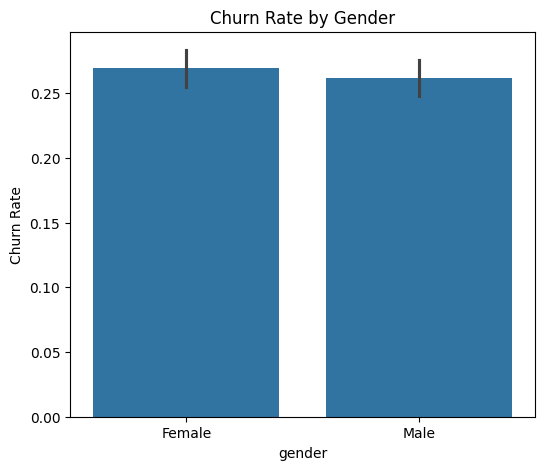

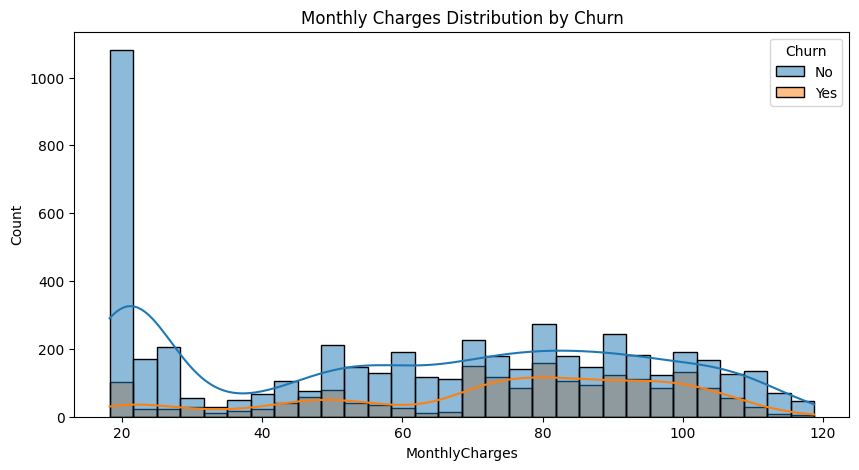

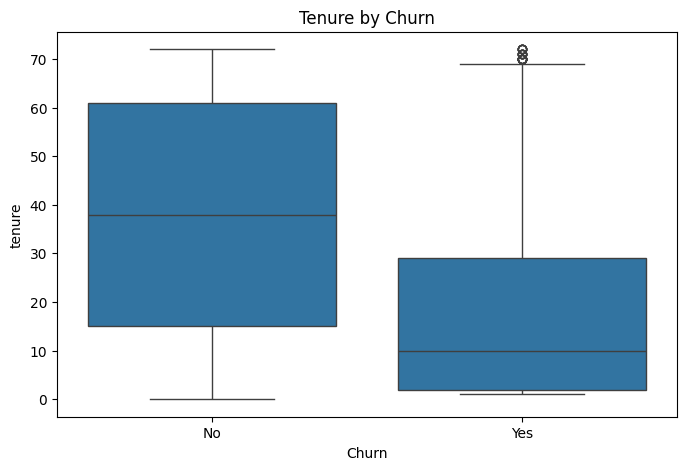

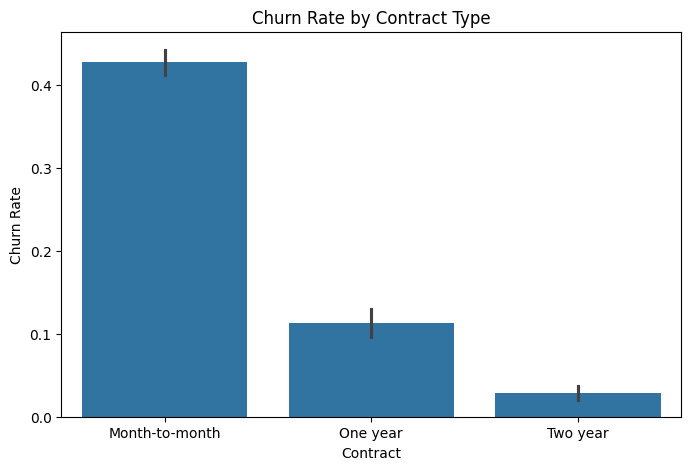

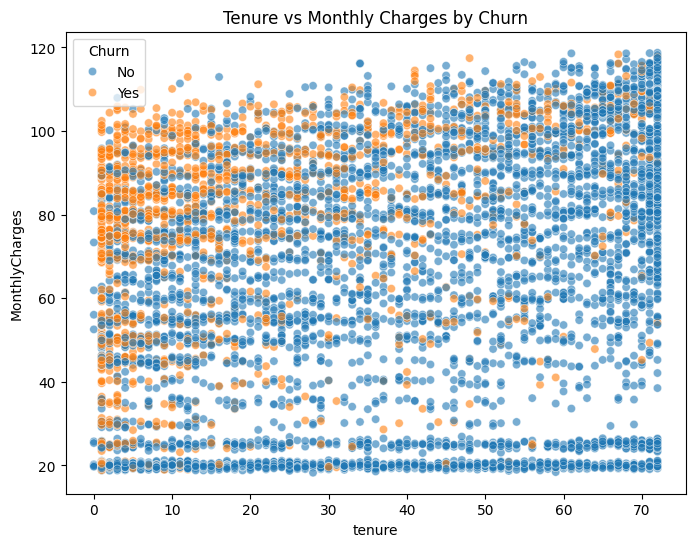

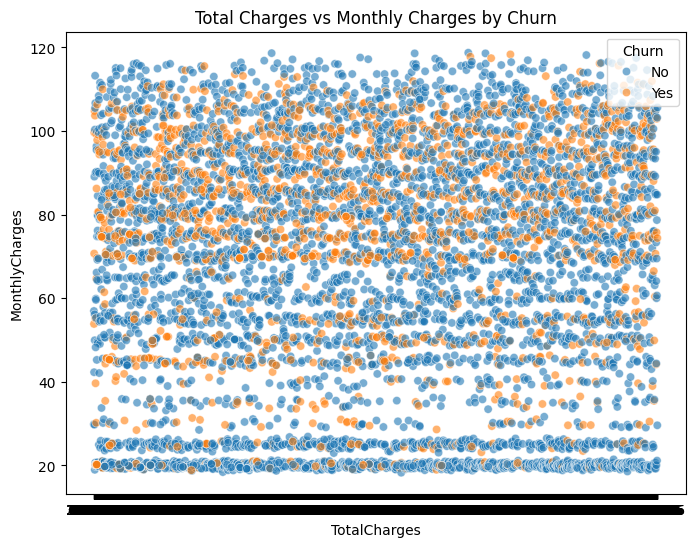

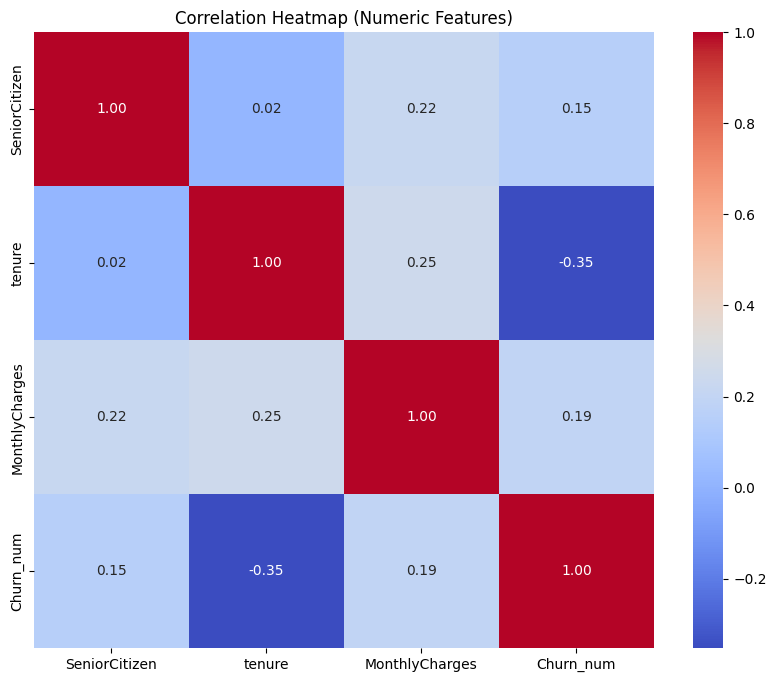

In [11]:
# Convert churn to numeric (0/1) for easier analysis
df["Churn_num"] = df["Churn"].map({"Yes": 1, "No": 0})

# --- Churn Rate by Gender ---
# Why: Logistic/linear models assume predictors can explain churn.
# Checking gender shows if it has predictive power for churn.
plt.figure(figsize=(6,5))
sns.barplot(x="gender", y="Churn_num", data=df)
plt.title("Churn Rate by Gender")
plt.ylabel("Churn Rate")
plt.show()

# --- Distributions: Monthly Charges by Churn ---
# Why: MonthlyCharges is continuous, important in both linear & logistic models.
# Distribution by churn shows if churners pay more.
plt.figure(figsize=(10,5))
sns.histplot(data=df, x="MonthlyCharges", kde=True, bins=30, hue="Churn")
plt.title("Monthly Charges Distribution by Churn")
plt.show()

# --- Boxplot: Tenure by Churn ---
# Why: Tenure is a numeric predictor. Linear models assume a relationship with churn.
# This shows if shorter tenure customers churn more (expected negative effect).
plt.figure(figsize=(8,5))
sns.boxplot(x="Churn", y="tenure", data=df)
plt.title("Tenure by Churn")
plt.show()

# --- Churn by Contract Type ---
# Why: Contract is categorical. Logistic regression and GAMs treat this as factors.
# Checking churn rates by contract length shows its predictive strength.
plt.figure(figsize=(8,5))
sns.barplot(x="Contract", y="Churn_num", data=df)
plt.title("Churn Rate by Contract Type")
plt.ylabel("Churn Rate")
plt.show()

# --- Scatter: Tenure vs MonthlyCharges ---
# Why: Assumptions like linearity/logit can be checked visually.
# Scatter shows interactions between two numeric predictors and churn patterns.
plt.figure(figsize=(8,6))
sns.scatterplot(x="tenure", y="MonthlyCharges", hue="Churn", data=df, alpha=0.6)
plt.title("Tenure vs Monthly Charges by Churn")
plt.show()

# --- Scatter: TotalCharges vs MonthlyCharges ---
# Why: TotalCharges is strongly related to tenure × monthly charges.
# Scatter helps spot multicollinearity issues before regression.
plt.figure(figsize=(8,6))
sns.scatterplot(x="TotalCharges", y="MonthlyCharges", hue="Churn", data=df, alpha=0.6)
plt.title("Total Charges vs Monthly Charges by Churn")
plt.show()

# --- Correlation Heatmap (numeric only) ---
# Why: All regression models assume no multicollinearity.
# Heatmap shows if numeric predictors are too correlated.
plt.figure(figsize=(10,8))
sns.heatmap(df.drop("customerID", axis=1).corr(numeric_only=True),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


Below is the interpetation of the graphs:

**Churn Rate by Gender** → Male and female customers churn at almost the same rate, so gender is not a strong predictor.

**Monthly Charges Distribution by Churn** → Customers with higher monthly charges are more likely to churn.

**Tenure by Churn (Boxplot)** → Churners tend to have shorter tenures, while long-tenure customers are more likely to stay.

**Churn Rate by Contract Type**  → Month-to-month customers churn the most, while two-year contract customers churn the least.

**Tenure vs Monthly Charges by Churn (Scatter)** → Most churn happens among customers with low tenure and mid-to-high monthly charges.

**Total Charges vs Monthly Charges by Churn (Scatter**) → Churners cluster around low total charges (short tenure) despite similar monthly charges.

**Correlation Heatmap** → Tenure has the strongest negative correlation with churn (-0.35), confirming that longer-staying customers churn less.

In [8]:
'''    Split the data into training and test sets
 and encode '''

X = df.drop(["Churn"], axis=1)    # keep as DataFrame
# Convert Yes → 1, No → 0
y = df["Churn"].map({"Yes": 1, "No": 0})
#y_scaled = y.astype(int)  # converts True→1, False→0
# Identify categorical and numeric columns. dtype object contains text strings.
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

# One-hot encode categorical columns
X_cat = pd.get_dummies(X[cat_cols], drop_first=True, dtype=int)
# Scale numeric features
scaler = StandardScaler()
X_num = pd.DataFrame(
    scaler.fit_transform(X[num_cols]),
    columns=num_cols,
    index=X.index
)

X_scaled = pd.concat([X_num, X_cat], axis=1)

print(X_scaled[:5])   # first 5 rows
print(y[:5])


   SeniorCitizen    tenure  MonthlyCharges  customerID_0003-MKNFE  \
0      -0.439916 -1.277445       -1.160323                      0   
1      -0.439916  0.066327       -0.259629                      0   
2      -0.439916 -1.236724       -0.362660                      0   
3      -0.439916  0.514251       -0.746535                      0   
4      -0.439916 -1.236724        0.197365                      0   

   customerID_0004-TLHLJ  customerID_0011-IGKFF  customerID_0013-EXCHZ  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   
4                      0                      0                      0   

   customerID_0013-MHZWF  customerID_0013-SMEOE  customerID_0014-BMAQU  ...  \
0                      0                      0              

In [9]:
# Split the data into training and test sets
X_train,X_test,y_train,y_test = train_test_split(X_scaled, y,test_size=0.2, random_state=42)


**Assumption Check** : Validate model requirements (like linearity, independence, equal variance, and lack of multicollinearity) to ensure reliable results.

In [20]:
def check_assumptions(X, y, model_type="linear", fitted_model=None):
    """
    Run assumption checks depending on model type.
    X = pandas DataFrame (keep column names)
    y = pandas Series
    model_type: "linear", "logistic", or "gam"
    fitted_model: pass a statsmodels fitted model to avoid refitting
    """
    import statsmodels.api as sm
    import seaborn as sns
    import matplotlib.pyplot as plt
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.stats.diagnostic import het_breuschpagan
    from statsmodels.stats.stattools import durbin_watson
    from scipy import stats
    import pandas as pd
    import numpy as np

    results = {}

    # ----------------- LINEAR REGRESSION -----------------
    if model_type == "linear":
        model = fitted_model if fitted_model else sm.OLS(y, sm.add_constant(X)).fit()
        residuals = model.resid
        predictions = model.predict()

        # 1. Linearity
        # Why: Linear regression assumes predictors relate linearly to target
        # Interpret: If residuals show a curve → violation (consider transformation or GAM)
        sns.residplot(x=predictions, y=residuals, lowess=True,
                      line_kws={"color": "red"})
        plt.title("Residual Plot (Linearity)")
        plt.show()

        # 2. Independence
        # Why: Residuals must not be correlated across observations
        # Interpret: Durbin-Watson ≈ 2 = independent; <1 or >3 = autocorrelation
        results["Durbin-Watson"] = durbin_watson(residuals)

        # 3. Homoscedasticity
        # Why: Variance of errors should be constant across predictions
        # Interpret: p < 0.05 (Breusch-Pagan) = unequal variance (heteroscedasticity)
        bp_test = het_breuschpagan(residuals, model.model.exog)
        results["Breusch-Pagan p-value"] = bp_test[1]

        # 4. Normality of residuals
        # Why: Needed for valid confidence intervals and hypothesis tests
        # Interpret: Q-Q plot deviates from line OR Shapiro p < 0.05 → residuals not normal
        sm.qqplot(residuals, line="s")
        plt.title("Q-Q Plot (Normality)")
        plt.show()
        results["Shapiro-Wilk p-value"] = stats.shapiro(residuals)[1]

        # 5. Multicollinearity
        # Why: Predictors shouldn’t strongly overlap (inflates variance of coefficients)
        # Interpret: VIF < 5 = fine; VIF > 5 = possible multicollinearity issue
        X_num = X.select_dtypes(include=["number"])
        vif = pd.DataFrame()
        vif["Variable"] = X_num.columns
        vif["VIF"] = [variance_inflation_factor(X_num.values, i)
                      for i in range(X_num.shape[1])]
        results["VIF"] = vif

        # 6. Outliers
        # Why: A single extreme observation can distort regression coefficients
        # Interpret: Cook’s Distance > 4/n = influential outlier worth investigating
        influence = model.get_influence()
        c, _ = influence.cooks_distance
        sample_idx = np.random.choice(range(len(c)), size=min(1000, len(c)), replace=False)
        plt.scatter(sample_idx, c[sample_idx], alpha=0.5)
        plt.axhline(4/len(c), color="red", linestyle="--")
        plt.title("Cook’s Distance (Outliers, sampled)")
        plt.show()

    # ----------------- LOGISTIC REGRESSION -----------------
    elif model_type == "logistic":
        # Use statsmodels.api.Logit for assumption checks
        logit_model = sm.Logit(y, sm.add_constant(X)).fit(disp=0)

        # 1. Linearity of logit
        # Why: Predictors should have a linear relation with log-odds of outcome
        # Interpret: If curves deviate from straight line → violation (use interactions or GAM)
        for col in ["tenure", "MonthlyCharges", "TotalCharges"]:
            if col in X.columns:
                sns.regplot(x=X[col], y=y, logistic=True, ci=None)
                plt.title(f"Linearity check for {col}")
                plt.show()

        # 2. Independence
        # Same as linear regression
        results["Durbin-Watson"] = durbin_watson(logit_model.resid_response)

        # 3. Multicollinearity
        # Same rationale and interpretation as linear regression
        X_num = X.select_dtypes(include=["number"])
        vif = pd.DataFrame()
        vif["Variable"] = X_num.columns
        vif["VIF"] = [variance_inflation_factor(X_num.values, i)
                      for i in range(X_num.shape[1])]
        results["VIF"] = vif

        # 4. Outliers
        # Why: Outliers can skew probability estimates
        # Interpret: High Cook’s Distance → influential observation
        influence = logit_model.get_influence()
        c, _ = influence.cooks_distance
        sample_idx = np.random.choice(range(len(c)), size=min(1000, len(c)), replace=False)
        plt.scatter(sample_idx, c[sample_idx], alpha=0.5)
        plt.axhline(4/len(c), color="red", linestyle="--")
        plt.title("Cook’s Distance (Outliers, sampled)")
        plt.show()

    # ----------------- GAM -----------------
    elif model_type == "gam":
        # GAMs already relax linearity, so fewer checks needed

        # 1. Independence
        # Why: Observations must be independent for reliable inference
        # Interpret: Check GAM residuals after fitting → DW ≈ 2 = good
        results["Durbin-Watson"] = "Check GAM residuals after fitting (≈2 = good)"

        # 2. Multicollinearity
        # Why: Strongly correlated predictors can destabilize smooth terms
        # Interpret: VIF < 5 = fine; > 5 = collinearity concern
        X_num = X.select_dtypes(include=["number"])
        vif = pd.DataFrame()
        vif["Variable"] = X_num.columns
        vif["VIF"] = [variance_inflation_factor(X_num.values, i)
                      for i in range(X_num.shape[1])]
        results["VIF"] = vif

        # 3. Outliers
        # Why: Outliers can distort smooth curves
        # Interpret: Check Cook’s Distance after GAM fit → large values = influence
        results["Outliers"] = "Check Cook’s Distance after fitting GAM"

    return results

**Linear Regression:**




Assumptions check for the linear model

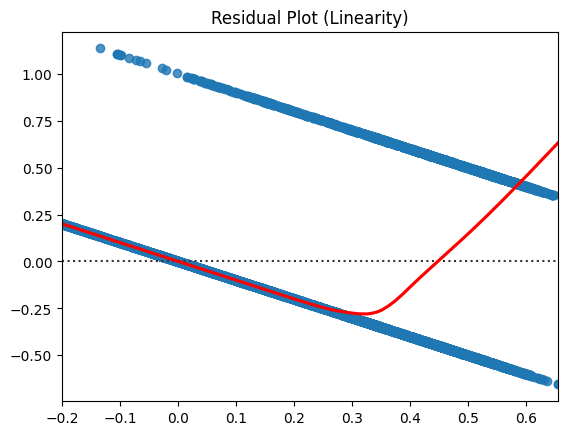

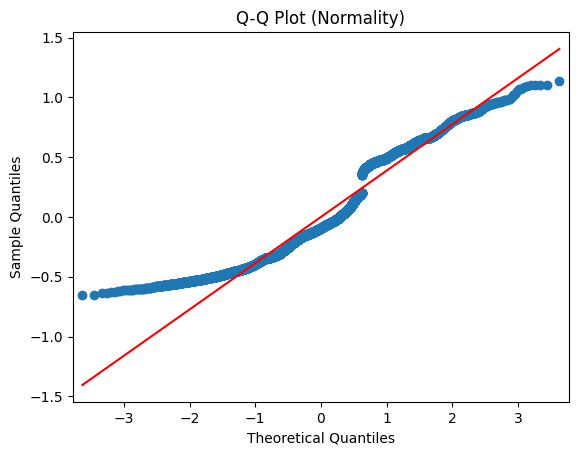

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7043.
  res = hypotest_fun_out(*samples, **kwds)


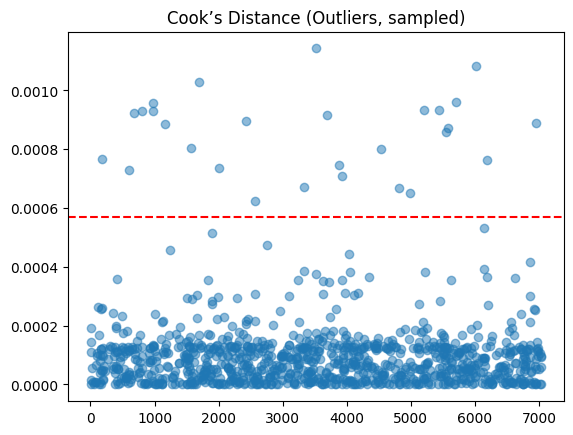

{'Durbin-Watson': np.float64(2.0171959259649426), 'Breusch-Pagan p-value': np.float64(0.0), 'Shapiro-Wilk p-value': np.float64(6.403366380679024e-49), 'VIF':             Variable       VIF
0             tenure  6.006071
1     MonthlyCharges  2.825845
2  Contract_One year  1.736881
3  Contract_Two year  2.717134}


In [ ]:
# Select only key features from EDA
X_focus = df[["tenure", "MonthlyCharges", "Contract"]]
X_focus = pd.get_dummies(X_focus, drop_first=True).astype(float)  # ensure numeric

y_focus = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)  # keep as Series, not .values

# Fit linear regression (for assumption checks)
lin_model = sm.OLS(y_focus, sm.add_constant(X_focus)).fit()

# Run assumption checks only on top features
results = check_assumptions(X_focus, y_focus, model_type="linear", fitted_model=lin_model)
print(results)

**Residual Plot (Linearity)**
The red smooth line curves noticeably, which means the relationship between predictors and churn is not perfectly linear. Linear regression assumption of linearity is violated.

**Q-Q Plot (Normality of Residuals)**
The blue points deviate strongly from the diagonal line, especially at the tails.Residuals are not normally distributed, violating linear regression’s normality assumption.

**Cook’s Distance (Outliers)**
Most points are below the red cutoff line, but some are close or above it.A few influential outliers exist, but not enough to dominate the model.

**Durbin-Watson: 2.02**
Value close to 2 means no autocorrelation in residuals. The independence assumption is satisfied.

**Breusch-Pagan p-value: 0.0**
Very low p-value → rejects null hypothesis of constant variance. Residuals show unequal variance, which is a violation of linear regression.

**Shapiro-Wilk p-value: ~6e-49**
Extremely small p-value → residuals are not normal.Normality assumption is violated.

**VIF (Multicollinearity)**
Tenure shows a multicollinearity issue (VIF ≈ 6), while MonthlyCharges and Contract are within acceptable limits.

Linear regression assumptions are not met — linearity, homoscedasticity, and normality are violated, and multicollinearity exists.

Evaluating the Linear model:

In [10]:
# Make sure data is numeric
X_train = pd.get_dummies(X_train, drop_first=True).astype(float)
X_test = pd.get_dummies(X_test, drop_first=True).astype(float)

# Align columns in case train/test differ after dummies
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# Ensure target is int
y_train = y_train.astype(int)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
# Predict
y_pred_lin = lin_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred_lin)
r2 = r2_score(y_test, y_pred_lin)

print("\n=== Linear Regression ===")
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Coefficients
for feature, coef in zip(X.columns, lin_model.coef_):
    print(f"{feature}: {coef:.4f}")



=== Linear Regression ===
MSE: 0.14
R² Score: 0.29
customerID: 0.0150
gender: -0.1025
SeniorCitizen: -0.1016
Partner: -0.2032
Dependents: 0.2965
tenure: 0.1921
PhoneService: 0.2337
MultipleLines: -0.1831
InternetService: -0.0443
OnlineSecurity: -0.0531
OnlineBackup: -0.2398
DeviceProtection: -0.0000
TechSupport: -0.0017
StreamingTV: -0.0283
StreamingMovies: -0.0000
Contract: -0.0499
PaperlessBilling: 0.0195
PaymentMethod: -0.0907
MonthlyCharges: -0.0000
TotalCharges: -0.3581


**Model Fit**

MSE: 0.14
R²: 0.29 → The model explains about 29% of the variation in the target.

Observing the coefficients,

* Partner (-0.2032) → indicats that customers having a partner, have a lower
churn risk.
* TotalCharges (-0.3581) → indicates that customers who have spent more are much less likely to churn.
*  Dependents (0.2965) → indicats that customers having dependents,have an increased churn risk.
*  Tenure (0.1921) →  indicats that longer the customers tenure, increased is the churn risk. (This does not seem plausible, since when a high customer tenture indicates lower risk of churn.
*  Many features have near-zero impact (DeviceProtection, Streaming, MonthlyCharges).

The model explains only 29% of churn variation and linear regression does not capture the complexity.





**Logistic Regression model:**

Assumptions check for the logistic model

Optimization terminated successfully.
         Current function value: 0.436311
         Iterations 8


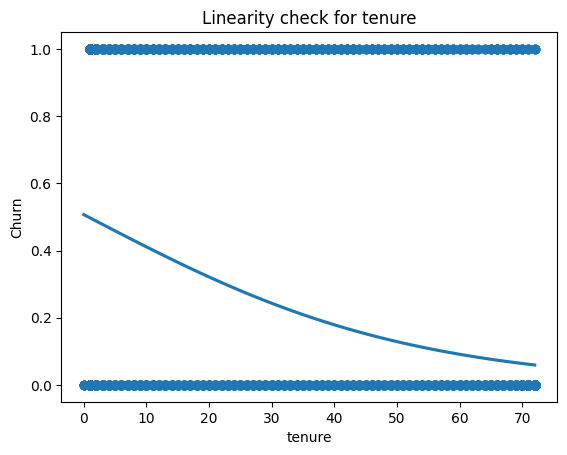

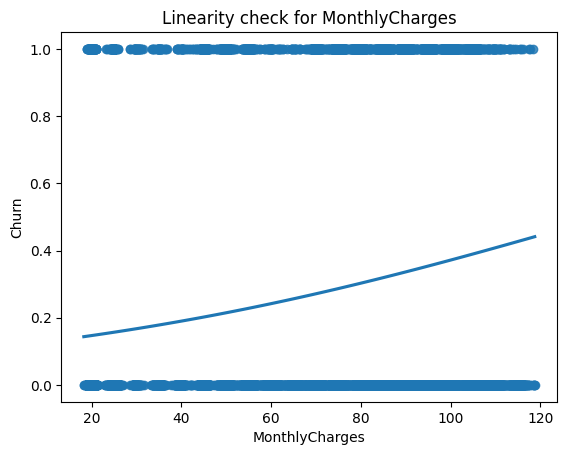

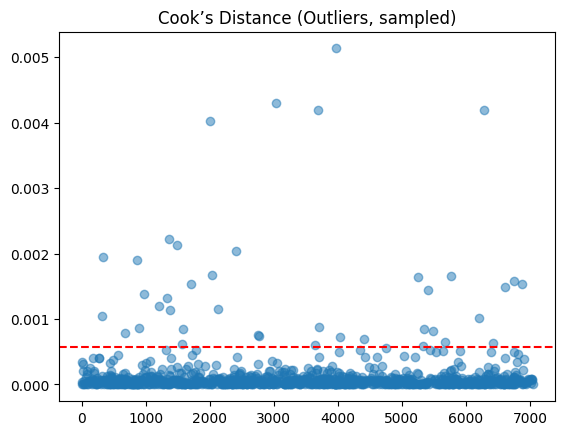

{'Durbin-Watson': np.float64(2.0126248941863336), 'VIF':             Variable       VIF
0             tenure  6.006071
1     MonthlyCharges  2.825845
2  Contract_One year  1.736881
3  Contract_Two year  2.717134}


In [ ]:
# Select only key features
X_focus = df[["tenure", "MonthlyCharges", "Contract"]]
X_focus = pd.get_dummies(X_focus, drop_first=True).astype(float)

# Encode target
y_focus = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)

# Fit with statsmodels Logit (for assumptions)
logit_model = sm.Logit(y_focus, sm.add_constant(X_focus)).fit()

# Run assumption checks
results = check_assumptions(X_focus, y_focus, model_type="logistic", fitted_model=logit_model)
print(results)

**Linearity of logit:**
* Tenure shows a strong non-linear negative relationship with churn
* MonthlyCharges shows a positive non-linear relationship,
so the linearity assumption is partially violated.

**Durbin-Watson**:
(≈2), Residuals are independent, so the independence assumption is met.

**VIF values:**
* Tenure (≈6) indicates multicollinearity
* MonthlyCharges (~2.8) and Contract are acceptable

**Cook’s Distance:**
A few influential outliers exist, but most points are well below the cutoff, indicating no major concern.

Logistic regression is usable, but tenure’s non-linearity and multicollinearity should be addressed .

Model Evaluation:

In [ ]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Predict
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:,1]

# Evaluate
print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred_log))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_log):.3f}")

# Coefficients
for feature, coef in zip(X.columns, log_model.coef_[0]):
    print(f"{feature}: {coef:.4f}")



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1036
           1       0.70      0.59      0.64       373

    accuracy                           0.82      1409
   macro avg       0.78      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409

ROC-AUC Score: 0.861
customerID: 0.0636
gender: -0.8275
SeniorCitizen: 0.0011
Partner: -0.2712
Dependents: 0.2470
tenure: 0.1948
PhoneService: 0.2619
MultipleLines: -0.2353
InternetService: -0.0308
OnlineSecurity: -0.0261
OnlineBackup: -0.2483
DeviceProtection: 0.0000
TechSupport: -0.0158
StreamingTV: -0.0265
StreamingMovies: 0.0000
Contract: -0.0322
PaperlessBilling: -0.0116
PaymentMethod: -0.0445
MonthlyCharges: 0.0000
TotalCharges: -0.5474


**Model Fit:**

Accuracy = 82%

Precision (churn = 0.70) i.e. the mode is 70% right when predicting churn.

Recall (churn = 0.59) i.e. model catches 59% of actual churners.

F1 (churn = 0.64) i.e. adequate in balancing catching churners (recall) and being correct when it predicts churn (precision).

ROC-AUC = 0.861 i.e. strong ability to distinguish churners vs non-churners.

Observing the coefficients, the most meaningful predictors are:
TotalCharges (strong negative):customers who’ve already paid a lot are loyal.
Partner (negative):customers with partners churn less.
Dependents (positive):slightly higher churn.
PhoneService (positive):churn risk increases.
Features that dropped out (0 or near 0): DeviceProtection, MonthlyCharges, Streaming, etc.

This model performs well overall with 82% accuracy and strong separation power (ROC-AUC = 0.86), though recall (59%) shows it misses some churners.


In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False).head(10))

**Random Forest** : used because it can capture complex, non-linear relationships and interactions that logistic regression may miss.

Observation:

* Churn is most strongly driven by tenure and MonthlyCharges
* Contract type and Payment method are also important.
* Value-added services like OnlineSecurity, TechSupport, and OnlineBackup play a smaller but still protective role against churn.

In [ ]:
lasso = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000)
lasso.fit(X_train, y_train)
print(dict(zip(X_train.columns, lasso.coef_[0])))

{'SeniorCitizen': np.float64(0.06257885548728319), 'tenure': np.float64(-0.7903867257490313), 'MonthlyCharges': np.float64(0.310402637717329), 'customerID_0003-MKNFE': np.float64(0.0), 'customerID_0004-TLHLJ': np.float64(0.0), 'customerID_0011-IGKFF': np.float64(0.0), 'customerID_0013-EXCHZ': np.float64(0.0), 'customerID_0013-MHZWF': np.float64(0.0), 'customerID_0013-SMEOE': np.float64(0.0), 'customerID_0014-BMAQU': np.float64(0.0), 'customerID_0015-UOCOJ': np.float64(0.0), 'customerID_0016-QLJIS': np.float64(0.0), 'customerID_0017-DINOC': np.float64(0.0), 'customerID_0017-IUDMW': np.float64(0.0), 'customerID_0018-NYROU': np.float64(0.0), 'customerID_0019-EFAEP': np.float64(0.0), 'customerID_0019-GFNTW': np.float64(0.0), 'customerID_0020-INWCK': np.float64(0.0), 'customerID_0020-JDNXP': np.float64(0.0), 'customerID_0021-IKXGC': np.float64(0.0), 'customerID_0022-TCJCI': np.float64(0.0), 'customerID_0023-HGHWL': np.float64(0.0), 'customerID_0023-UYUPN': np.float64(0.0), 'customerID_0023-

**(Lasso) logistic regression**:

Used alternatively to let the model itself drop weak features.

Observation:

* Tenure is the dominant protective factor: the longer someone stays, the less likely they are to leave.
* Monthly Charges is the main risk factor: higher bills push customers out.
* Senior Citizen adds a slight risk, but it’s much smaller than tenure or charges.

**Generalized Additive Model (GAM)**

Features are selected for the GAM based on LAsso & RandomForet Classifier obsrvations.

{'Durbin-Watson': 'Check GAM residuals after fitting (≈2 = good)', 'VIF':          Variable       VIF
0   SeniorCitizen  1.256364
1          tenure  2.617403
2  MonthlyCharges  2.924996, 'Outliers': 'Check Cook’s Distance after fitting GAM'}
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     31.3034
Link Function:                        LogitLink Log Likelihood:                                 -2919.8757
Number of Samples:                         7043 AIC:                                             5902.3583
                                                AICc:                                            5902.6652
                                                UBRE:                                               2.8416
         

/tmp/ipython-input-829806258.py:35: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


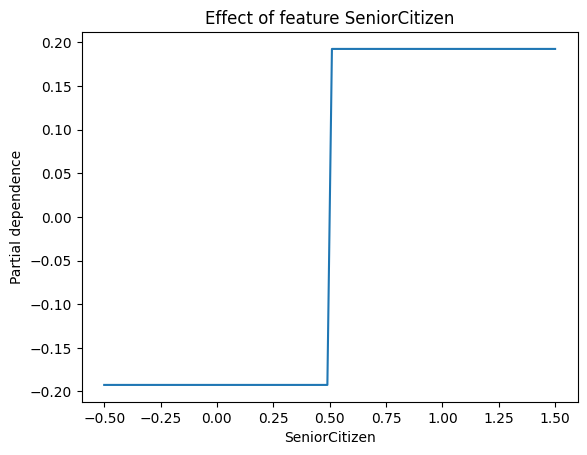

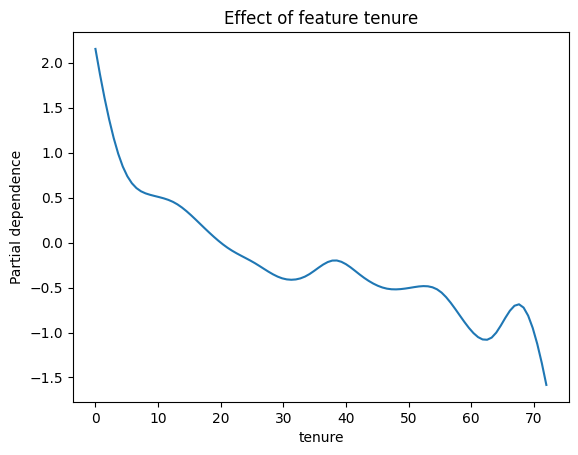

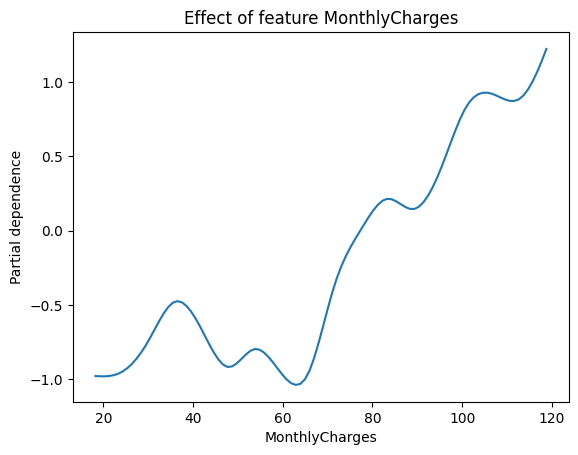

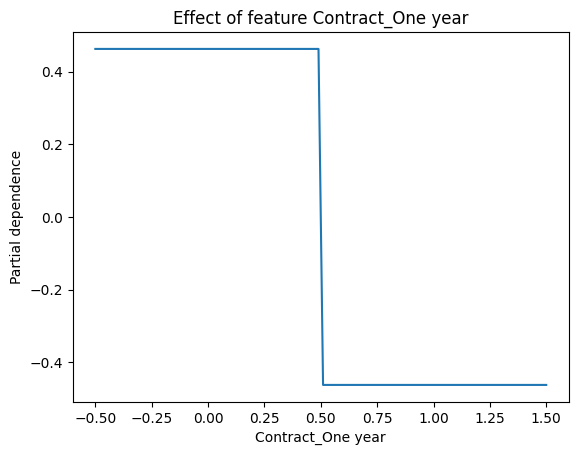

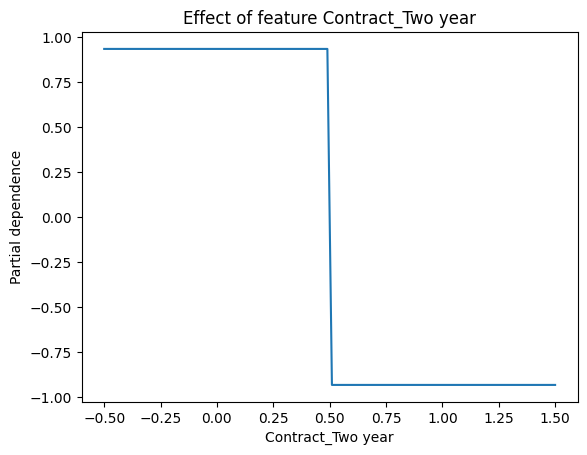

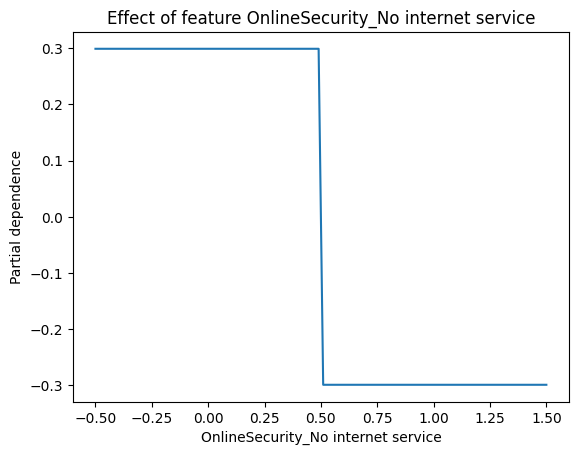

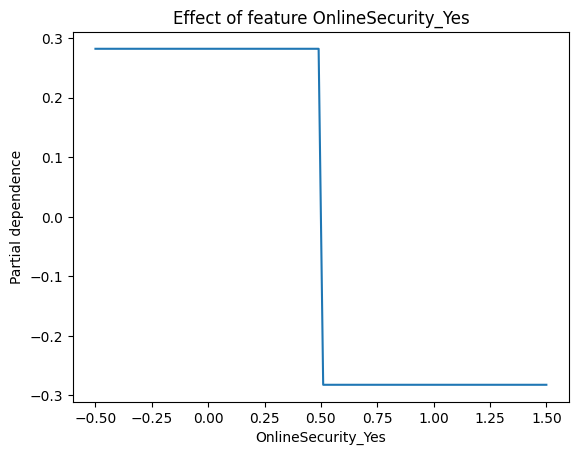

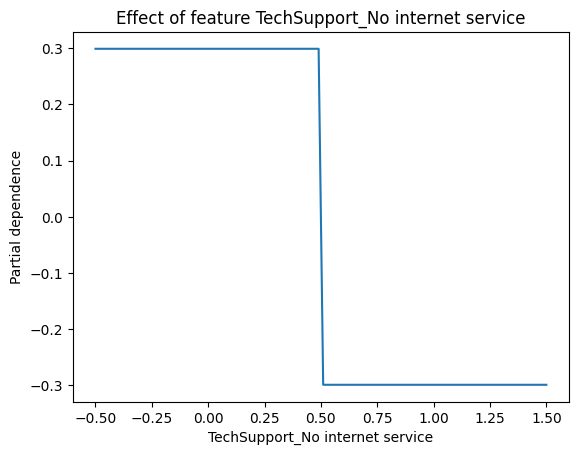

In [ ]:
# --- 1. Prepare target ---
y = df["Churn"].map({"Yes": 1, "No": 0}).values

# --- 2. Select features ---
features = [
    "SeniorCitizen", "tenure", "MonthlyCharges",
    "Contract", "OnlineSecurity", "TechSupport", "OnlineBackup"
]
X = df[features]

# --- 3. Encode categoricals ---
X_encoded = pd.get_dummies(X, drop_first=True)

# --- 4. Convert to numpy ---
X = X_encoded.values

# --- 4. Assumption Checks ---
# Use X_encoded (pandas DataFrame) so it still has column names
results = check_assumptions(X_encoded, y, model_type="gam")  # or "logistic"/"linear"
print(results)

# --- 5. Build GAM ---
# tenure = s(), MonthlyCharges = s(), others = f()
# Index order depends on how get_dummies expanded columns
# First col = SeniorCitizen (binary), next are one-hot dummies

gam = LogisticGAM(
    f(0) +             # SeniorCitizen
    s(1) +             # tenure
    s(2) +             # MonthlyCharges

    f(3) + f(4) + f(5) + f(6) + f(7)  # Contract & service dummies
).fit(X, y)

# --- 6. Print summary ---
print(gam.summary())

# --- 7. Plot smooth effects for tenure & charges ---
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    if term.n_splines > 1:  # smooth terms only
        XX = gam.generate_X_grid(term=i)
        plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
        plt.title(f"Effect of feature {X_encoded.columns[i]}")
        plt.xlabel(X_encoded.columns[i])
        plt.ylabel("Partial dependence")
        plt.show()

**Model Fit:**

Distribution: Binomial → This is a logistic model (churn is Yes/No).

Link Function: Logit → Standard logistic regression link.

Log Likelihood: -2919.9 (binomial likelihood).

Pseudo R-Squared: 0.2835 → The model explains ~28% of the variation in churn.

Interpretation:

* Tenure, charges, and contract type are the biggest churn drivers.
* MonthlyCharges are one of the strongest churn predictors. Customers with higher bills are significantly more likely to leave — but the risk grows in a curved pattern, not a straight line.
* Value-added services (security, tech support, backup) do help reduce churn, but the effect is smaller.
* Seniors churn slightly more, though the effect isn’t as strong as tenure/charges.

The logistic GAM fits churn reasonably well, explaining about 28% of the variation.


**Model Comparison** :

1. **Linear Regression**

•	Explains only ~29% of variation.

•	Not appropriate for a binary target (churn = Yes/No).

Strengths: Simple baseline, easy to compute.

Weaknesses: Statistically inappropriate for churn, lower accuracy, poor handling of binary outcomes.

*Use only as a learning baseline, not for real decision-making.*

2. **Logistic Regression**

Accuracy ≈ 82%, ROC-AUC ≈ 0.86.

Strong at separating churners vs non-churners.

Strengths: Good standard for binary outcomes. Can rank customers by churn risk and

Weaknesses: Recall for churners was only ~59% (misses 4 in 10 churners). Assumes linear log-odds relationships. Struggles with complex non-linear patterns (e.g., charges only matter above $70).

*Best balance of accuracy and interpretability.Should be the baseline churn model.*

3. **Generalized Additive Model (GAM)**

Explains ~28% of variation.

Captures non-linear effects (e.g., churn risk drops sharply in first 6 months, then flattens).

Strengths: Handles non-linearities smoothly.

Weaknesses: More complex to fit/tune.

*Excellent for deep analysis and pattern discovery, but less straightforward for deployment.*




**Recommendation**

Logistic regression should be used as the churn model as it predicts churn with 82% accuracy and is easy to explain. GAM analysis can be used alongside to understand non-linear thresholds. GAMs reveal deeper patterns, like exactly when high bills or short tenure trigger churn, which can be used for targeted interventions. Lasso should be used as a feature selection tool to focus on the most important drivers. Linear regression is not suitable for churn

Citation: Portions of the code were generated with the assistance of ChatGPT (OpenAI, 2025) solely for learning purposes